In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import cv2
import time
import random
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math
from scipy.spatial.transform import Rotation as R
import torchvision.models as models
import itertools
from scipy.ndimage import distance_transform_edt
import torchvision.transforms as T
import os

In [ ]:
#TODO
# calibrate basline image

#1. manual calibration with PNP
xyz_dir = './...' #specify directory to 3D coordinates of keypoints
xyz_smb = np.load(xyz_dir)

#2. load the 2D pixel coordinates of the keypoints
uv_dir = './...' #specify directory to 2D coordinates of keypoints
img_pts_arr = np.load(uv_dir)

#3. Specify the intrinsic parameters of the camera
K_base = np.array([[508.3997, 0, 316.0652],[0,677.8663,254.0068],[0, 0, 1]])

#4. Run the PnP ransac algorithm to compute R and T for the baseline image
dist_coeffs = np.zeros(4) #np.random.uniform(0,0.01,4)#
all_trans = []
all_rots = []
for ji in range(100):
    inds = random.sample(range(len(xyz_smb)), 10)
    success, rvec, tvec, inliers = cv2.solvePnPRansac(
        xyz_smb.astype(np.float32)[inds,:], img_pts_arr.astype(np.float32)[inds,:], K_base, dist_coeffs,
        reprojectionError=3.0,
        confidence=0.99,
        flags=cv2.SOLVEPNP_ITERATIVE
    )
    if success:
        Rm, _ = cv2.Rodrigues(rvec)
        trans = (-Rm.T@tvec).flatten()
        all_trans.append(trans)
        all_rots.append(Rm)

T_base = np.median(np.array(all_trans),0)
R_base = np.median(np.array(all_rots),0)

In [2]:
## Calibrated parameters for UIUC smart bridge is given here
K_base = np.array([[508.3997, 0, 316.0652],[0,677.8663,254.0068],[0, 0, 1]])
T_base = np.array([34.92314323, 11.66695466,  1.25144778])
R_base = np.array([[-0.22990146,  0.97289404, -0.02495011],
       [-0.28855094, -0.09262579, -0.95297367],
       [-0.92945343, -0.21189066,  0.30202429]])

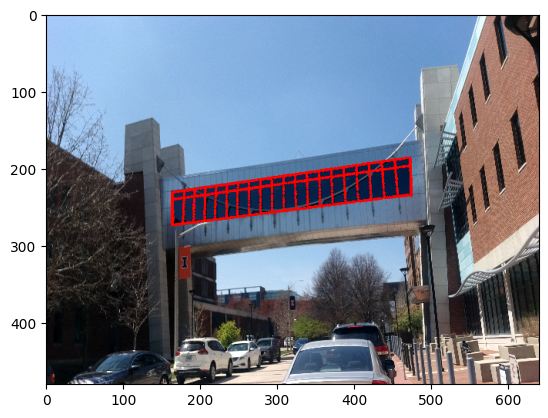

In [ ]:
#TODO
# Load the surrogate model, repoject, visualize and validate geometric accuracy and correctness of initial params.
img_base = cv2.imread('./INAF/codes/img149.png')
def gen_geom_smb():
    file_path = './INAF/codes/smb_3dcoords.txt'
    vertices = np.loadtxt(file_path)
    return vertices
XYZ = gen_geom_smb()

ZUV1 = K_base@R_base@(XYZ.T - T_base.reshape(-1,1))
UV1 = np.round(ZUV1/ZUV1[2:,:]).astype(np.int32)
U1, V1 = UV1[0,:], UV1[1,:]
h1, w1 = img_base.shape[0:2]
ind = (U1>=0)*(U1<w1)*(V1>=0)*(V1<h1)
U1, V1 = U1[ind], V1[ind]
blk_img = np.zeros((h1,w1,3))
for v, u in zip(V1, U1):
    cv2.circle(blk_img, (u, v), 1, (255,255,255), -1)
msk = blk_img>0
mks2 = np.all(blk_img == [255, 255, 255], axis=-1)
blk_img[mks2] = [0, 0, 255]
mcomb2 = (1-msk)*img_base + blk_img
plt.imshow(cv2.cvtColor(mcomb2.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
#TODO
## set the resolution of your baseline image(s) here
U2, V2 = np.meshgrid(np.arange(0,640), np.arange(0, 480))
U2, V2 = U2.flatten(), V2.flatten()
UV2 = np.vstack((U2, V2)).T
UV21 = np.hstack((UV2, np.ones((len(UV2),1))))

In [ ]:
#TODO
#using the identified T_base and R_base, and using K_base position a depth camera in Gazebo or blender to generate a depth map
#load the depth map for the baseline image(s)
dimg_base_ = np.load('./INAF/codes/dept_temp_0.npy')
hd,wd = dimg_base_.shape[0:2]
# If depth map is not aligned with the image, i.e., different K-matrix, allign here:
Z1 = dimg_base_.flatten()
K1 = np.array([385.477716, 0.0, 320, 0.0, 385.477716, 240, 0.0, 0.0, 1.0]).reshape(3,3)
Z2U2 = K_base@(np.linalg.inv(K1))@(Z1*UV21.T)
dimg_base = Z2U2[-1,:].reshape(hd,wd)

In [6]:
def minmax(x, lim):
    return np.minimum(np.maximum(x,0),lim)

In [7]:
def msk_pr(img, K1, R1, T1):
    """This function computes the mask used to isolate the target stucture in the image""" 
    h,w = img.shape[0:2]
    #TODO
    # provide the 3D bounding cordinates of the traget structure from the BIM/GBDT
    ## SMB - UIUC smart bridge
    xptss = np.array([[-1.04,-10.4,10.97],[-1.03,-10.7,14.4],[-1.03,-10.92,16.96],
                        [-1.03,-1.42,16.96],[-1.03,5.89,16.96],[-1.03,12.91,16.96],
                        [-1.03,16.65,16.96],[-1.03,16.4,14.5],[-1.03,16.1,11.1],
                        [-1.03,10.2,11.1],[-1.03,4.69,11.1],[-1.03,-2.02,11.1],[-1.07,-10.39,10.97]])
    
    upt = K1@R1@(xptss.T - T1)
    up = np.floor(np.array(upt/upt[2:,:] + 0.5)).astype(np.int32)
    up = up[0:2,:]
    up[0,:] = minmax(up[0,:], w-1)
    up[1,:] = minmax(up[1,:], h-1)
    up = up.T
    if len(up)>=6:
        udiff = (up[:,0].max() - up[:,0].min())
        vdiff = (up[:,1].max() - up[:,1].min())
        if (udiff>=100) and (vdiff>=100):
            mask = np.zeros((h,w), dtype=np.uint8)
            cv2.fillPoly(mask, up[np.newaxis,:,:], 1)
            mask_ = np.stack([mask]*3,-1)
            return mask_

In [18]:
def trans_img12img(img, T1n, T2n, R1n, R2n, K1, K2, dimg2):
    img1 = np.array(img)
    h,w = img1.shape[0:2]
    T1 = np.array(T1n).reshape(-1,1)
    T2 = np.array(T2n).reshape(-1,1)
    R1 = np.array(R1n)
    R2 = np.array(R2n)
    mult_msk = msk_pr(img, K1, R1, T1)
    if mult_msk is not None:
        Z2 = dimg2[V2, U2].flatten()
        ZUV1 = K1@R1@(np.linalg.inv(K2@R2)@((Z2*UV21.T)) + T2 - T1) 
        UV1 = (np.floor(np.array(ZUV1/ZUV1[2:,:])+0.5)).astype(np.int16)
        h1,w1 = img1.shape[0:2]
        U1f = UV1[0,:]
        V1f = UV1[1,:]
        ind1 = (U1f<w1) * (U1f>=0) 
        ind2 = (V1f<h1) * (V1f>=0) 
        ind = ind1*ind2#*ind3
        U1, V1 = U1f[ind], V1f[ind]
        u2, v2 = U2[ind], V2[ind]
        blnk_img = np.zeros_like(img1)
        blnk_img[V1, U1, :] = img1[v2, u2, :]

        ## Bilinear interpolation to clean up the synthesized image
        mask = np.all(blnk_img == 0, axis=2)
        _, indices = distance_transform_edt(mask, return_indices=True)
        filled_img = blnk_img.copy()
        filled_img[mask] = blnk_img[indices[0][mask], indices[1][mask]]
        blnk_img_msk = mult_msk*filled_img
        return blnk_img_msk

In [9]:
zd = np.hstack((np.array([0.0]*3), np.array([0.0]*3)))
xp = np.hstack((np.array([0.5]*3), np.array([5.0]*3)))

In [10]:
def score(ms,gd,pr):
    sc = np.maximum(np.minimum((ms-pr)/(gd-pr), 1.0),0.0)
    return sc

In [11]:
def pt_trans(img, ph_trans = False):
    if ph_trans:
        img = torch.tensor(img)/255
        img = T.ToPILImage()(img)
        photometric_transforms = T.ColorJitter(
            brightness=0.5,
            contrast=0.5
        )
        img = photometric_transforms(img)
        img = T.ToTensor()(img)
        img = 255*img.squeeze(0).numpy()
    return img

In [12]:
def comb_imgs(imgi, T1_, qi, K1, rad=2, sz=300, rev=True, viz=False, ph_trans=False):
    imgi = cv2.cvtColor(imgi, cv2.COLOR_BGR2GRAY)
    imgi = pt_trans(imgi, ph_trans)
    imgi = np.stack([imgi]*3,-1)
    imgi = np.array(imgi).astype(np.uint8)
    if rev:
        ru1 = np.array(R.from_quat([qi[1],qi[2],qi[3],qi[0]]).as_euler('xyz',degrees=True))
    else:
        ru1 = np.array(R.from_quat(qi).as_euler('xyz',degrees=True))
    R1_ = np.array(R.from_euler('xyz', ru1, degrees=True).as_matrix())
    ZUV1 = K1@R1_@(XYZ.T - T1_)
    UV1 = np.round(ZUV1/ZUV1[2:,:]).astype(np.int32)
    U1, V1 = UV1[0,:], UV1[1,:]
    h1, w1 = imgi.shape[0:2]
    ind = (U1>=0)*(U1<w1)*(V1>=0)*(V1<h1)
    U1, V1 = U1[ind], V1[ind]
    blk_img = np.zeros_like(imgi[:,:,0])
    for v, u in zip(V1, U1):
        cv2.circle(blk_img, (u, v), rad, 255, -1)
    msk = blk_img>0
    blk_img[msk] = 255
    imgk = np.array(imgi)
    blk_img = np.stack([blk_img]*3,-1)
    mks2 = np.all(blk_img == [255, 255, 255], axis=-1)
    blk_img[mks2] = [0, 0, 255]
    mcomb = (1-msk[:,:,np.newaxis])*imgk + blk_img
    imgk_tsr = F.interpolate(torch.tensor(mcomb/255.0).permute(2,0,1).unsqueeze(0), size=(sz,sz), mode='bilinear', align_corners=False)
    mcomb_ = cv2.resize(mcomb.astype(np.uint8),(sz,sz),interpolation=cv2.INTER_LINEAR)
    return imgk_tsr.squeeze(0).float(), mcomb_

In [ ]:
def datagen(T_base, R_base, K_base, img_base, dimg_base, sz=300, viz=False, ns=10, tmin=-7.5, tmax=7.5, rmin=-15.0, rmax=15.0):
    T1_rel2, Q1_rel2 = [], []
    img_tsr_ls, img_ls = [], []
    scr_v = []
    for i in range(len(T_base)):
        img2 = img_base[i]
        T2 = np.array(T_base[i])
        R2 = np.array(R_base[i])
        dimg2 = dimg_base[i]
        r2eu = np.round(np.array(R.from_matrix(R2).as_euler('xyz',degrees=True)),3)
        for _ in range(ns): 
            dt = np.random.uniform(tmin, tmax, 3)
            dr = np.random.uniform(rmin, rmax, 3)
            rnn = np.random.uniform(0,1.0,1)
            if rnn<0.18: 
                dt2 = np.random.uniform(-0.01, 0.01, 3)
                dr2 = np.random.uniform(-0.0, 0.0, 3)
            elif (rnn>0.18) and (rnn<0.3):
                dt2 = np.random.uniform(-0.1, 0.1, 3)
                dr2 = np.random.uniform(-1.0, 1.0, 3)
            elif (rnn>0.3) and (rnn<0.45):
                dt2 = np.random.uniform(-0.2, 0.2, 3)
                dr2 = np.random.uniform(-3.0, 3.0, 3)
            elif (rnn>0.45) and (rnn<0.55):
                dt2 = np.random.uniform(-0.4, 0.4, 3)
                dr2 = np.random.uniform(-5.0, 5.0, 3)  
            elif (rnn>0.55) and (rnn<0.65):
                dt2 = np.random.uniform(-0.5, 0.5, 3)
                dr2 = np.random.uniform(-7.0, 7.0, 3)
            else:
                dt2 = np.random.uniform(-0.7, 0.7, 3) 
                dr2 = np.random.uniform(-10.0, 10.0, 3)
            
            T1 = T2+dt
            ru1 = r2eu+dr
            R1 = np.array(R.from_euler('xyz',ru1,degrees=True).as_matrix())
            K1_m = np.array(K_base[i]) 
            imgi = trans_img12img(img2, T1, T2, R1, R2, K1_m, K1_m, dimg2)
            
            
            if imgi is not None:
                T1_ = (T1+dt2)
                ms = np.hstack((np.abs(dt2), np.abs(dr2)))
                scr_v.append(np.mean(score(ms,zd,xp)).tolist())  
                T1_ = T1_.reshape(-1,1)
                qi2 = np.array(R.from_euler('xyz', ru1+dr2, degrees=True).as_quat())
                qi2 = (qi2/np.linalg.norm(qi2)).tolist()
                R_g_c2 = np.array(R.from_quat(qi2).as_matrix())
                R_c2_c1 = R1@R_g_c2.T
                q21 = np.array(R.from_matrix(R_c2_c1).as_quat())
                q21 = q21/np.linalg.norm(q21)
                Q1_rel2.append(np.array(R.from_quat(q21).as_euler('xyz',degrees=True)).tolist())
                T1_rel2.append(dt2.flatten().tolist())  
                ptrs = False
                rph = np.random.uniform(0,1.0,1)
                if rph>=0.5:
                    ptrs = True
                img_tsr, img_comb = comb_imgs(imgi, T1_, qi2, K1_m, sz=sz, rad=1, ph_trans=ptrs, viz=viz, rev=False)
                img_tsr_ls.append(img_tsr)
                img_ls.append(img_comb)
                
    if len(img_tsr_ls) >= 1:
        img_tsr_ls = torch.stack(img_tsr_ls,0).float()
        Q1_rel2_tsr = torch.tensor(Q1_rel2).float()
        T1_rel2_tsr = torch.tensor(T1_rel2).float()
        scr_tsr = torch.tensor(scr_v).float().reshape(-1,1) 
        return img_ls, img_tsr_ls, T1_rel2_tsr, Q1_rel2_tsr, scr_tsr

In [ ]:
#TODO
#specify path to save generated images and target prediction values
pos_dir = './INAF/0data/0_dir/'
score_dir = './INAF/0data/1_dir/'
img_dir = './INAF/0data/2_dir/'
if not(os.path.exists('./0data/')):
    os.makedirs('./INAF/0data/')
    os.makedirs('./INAF/0data/0_dir/')
    os.makedirs('./INAF/0data/1_dir/')
    os.makedirs('./INAF/0data/2_dir/')

In [21]:
#TODO
# If more than one baseline image is used, provide corresponding parameters for each input list below
T_base_all = [T_base]
R_base_all = [R_base]
K_base_all = [K_base]
img_base_all = [img_base]
dimg_base_all = [dimg_base]

Nmax = 10#50000 # Specify size of dataset
ldat = 0
ctm = 0
idp = 0
sz = 300 # Image resolution into the nuerall network

while ldat < Nmax:
    out = datagen(T_base_all, R_base_all, K_base_all, img_base_all, dimg_base_all, sz=sz)
    if out is not None:
        ldat += len(out[0])
        print("data len: ", ldat)
        for dd in range(len(out[0])):
            cv2.imwrite(img_dir+str(idp)+'img'+'.jpg',out[0][dd])
            pos_i = torch.hstack((out[2][dd,:], out[3][dd,:]))
            scr_i = out[-1][dd,:]
            torch.save(pos_i, pos_dir+str(idp)+'pose.pt')
            torch.save(scr_i, score_dir+str(idp)+'clsr.pt')
            idp+=1

data len:  10
